# Курсовая работа. Прогноз цен на недвижимость.

### Задание для курсового проекта

Метрика:
R2 - коэффициент детерминации (sklearn.metrics.r2_score)

Сдача проекта:
1. Прислать в раздел Задания Урока 10 ("Вебинар. Консультация по итоговому проекту")
ссылку на программу в github (программа должна содержаться в файле Jupyter Notebook 
с расширением ipynb). (Pull request не нужен, только ссылка ведущая на сам скрипт).
2. Приложить файл с названием по образцу SShirkin_predictions.csv
с предсказанными ценами для квартир из test.csv (файл должен содержать два поля: Id, Price).
В файле с предсказаниями должна быть 5001 строка (шапка + 5000 предсказаний).

Сроки и условия сдачи:
Дедлайн: сдать проект нужно в течение 72 часов после начала Урока 10 ("Вебинар. Консультация по итоговому проекту").
Для успешной сдачи должны быть все предсказания (для 5000 квартир) и R2 должен быть больше 0.6.
При сдаче до дедлайна результат проекта может попасть в топ лучших результатов.
Повторная сдача и проверка результатов возможны только при условии предыдущей неуспешной сдачи.
Успешный проект нельзя пересдать в целях повышения результата.
Проекты, сданные после дедлайна или сданные повторно, не попадают в топ лучших результатов, но можно узнать результат.
В качестве итогового результата берется первый успешный результат, последующие успешные результаты не учитываются.

Примечание:
Все файлы csv должны содержать названия полей (header - то есть "шапку"),
разделитель - запятая. В файлах не должны содержаться индексы из датафрейма.

Рекомендации для файла с кодом (ipynb):
1. Файл должен содержать заголовки и комментарии
2. Повторяющиеся операции лучше оформлять в виде функций
3. Не делать вывод большого количества строк таблиц (5-10 достаточно)
4. По возможности добавлять графики, описывающие данные (около 3-5)
5. Добавлять только лучшую модель, то есть не включать в код все варианты решения проекта
6. Скрипт проекта должен отрабатывать от начала и до конца (от загрузки данных до выгрузки предсказаний)
7. Весь проект должен быть в одном скрипте (файл ipynb).
8. При использовании статистик (среднее, медиана и т.д.) в качестве признаков,
лучше считать их на трейне, и потом на валидационных и тестовых данных не считать 
статистики заново, а брать их с трейна. Если хватает знаний, можно использовать кросс-валидацию,
но для сдачи этого проекта достаточно разбить данные из train.csv на train и valid.
9. Проект должен полностью отрабатывать за разумное время (не больше 10 минут),
поэтому в финальный вариант лучше не включать GridSearch с перебором 
большого количества сочетаний параметров.
10. Допускается применение моделей машинного обучения из библиотеки sklearn.

__Подключение бибилиотек__

In [1]:
import pandas as pd
import numpy as np
import sklearn as skl
import matplotlib
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, KFold, GridSearchCV, RepeatedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error as mse, r2_score as r2
from sklearn.decomposition import PCA
from sklearn.svm import SVR
from datetime import datetime

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
matplotlib.rcParams.update({'font.size': 14})

# Загрузка данных

In [4]:
TRAIN_DATASET_PATH = 'train.csv'
TEST_DATASET_PATH = 'test.csv'

In [5]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
test_df = pd.read_csv(TEST_DATASET_PATH)

**Описание датасета**

* **Id** - идентификационный номер квартиры
* **DistrictId** - идентификационный номер района
* **Rooms** - количество комнат
* **Square** - площадь
* **LifeSquare** - жилая площадь
* **KitchenSquare** - площадь кухни
* **Floor** - этаж
* **HouseFloor** - количество этажей в доме
* **HouseYear** - год постройки дома
* **Ecology_1, Ecology_2, Ecology_3** - экологические показатели местности
* **Social_1, Social_2, Social_3** - социальные показатели местности
* **Healthcare_1, Helthcare_2** - показатели местности, связанные с охраной здоровья
* **Shops_1, Shops_2** - показатели, связанные с наличием магазинов, торговых центров
* **Price** - цена квартиры

In [6]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.871089
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.553407
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.720850
3,2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.007630
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,B,B,33,8667,2,NaN,0,6,B,343995.102962


In [7]:
test_df = pd.read_csv(TEST_DATASET_PATH)
test_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,4567,44,1.0,36.847630,19.094182,5.0,5,9.0,1970,0.036122,B,B,24,4378,0,1036.0,1,1,B
1,5925,62,1.0,42.493907,42.568133,10.0,7,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A
2,960,27,2.0,59.463678,NaN,9.0,19,19.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B
3,3848,23,3.0,49.646030,33.893825,6.0,2,2.0,1965,0.014073,B,B,2,475,0,NaN,0,0,B
4,746,74,1.0,53.837056,NaN,1.0,8,17.0,1977,0.309479,B,B,35,7715,4,990.0,0,6,B


In [8]:
# в train на 1 столбец меньше, чем в test
train_df.shape[1] - 1 == test_df.shape[1]

True

# Целевое распределение признаков и корреляции

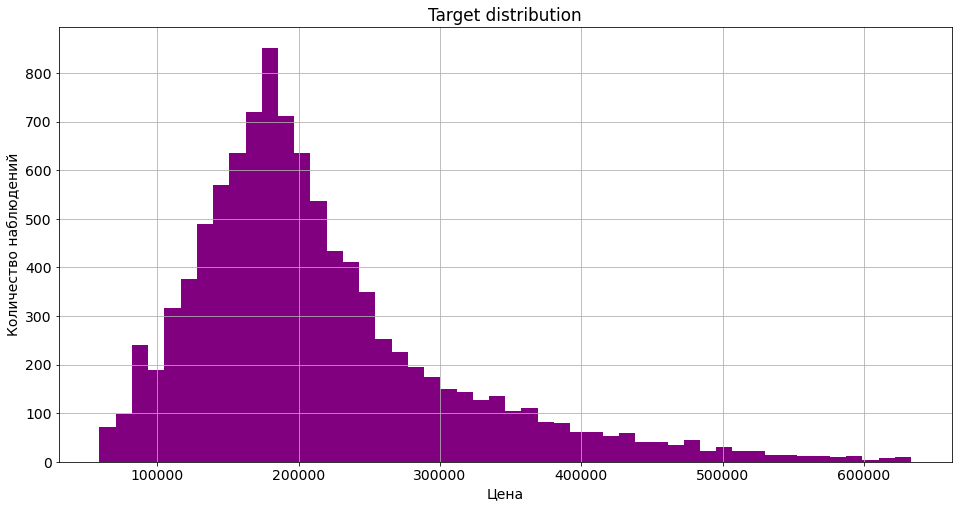

In [9]:
plt.figure(figsize = (16, 8))

train_df['Price'].hist(bins=50, color='purple')
plt.ylabel('Количество наблюдений')
plt.xlabel('Цена')

plt.title('Target distribution')
plt.show()

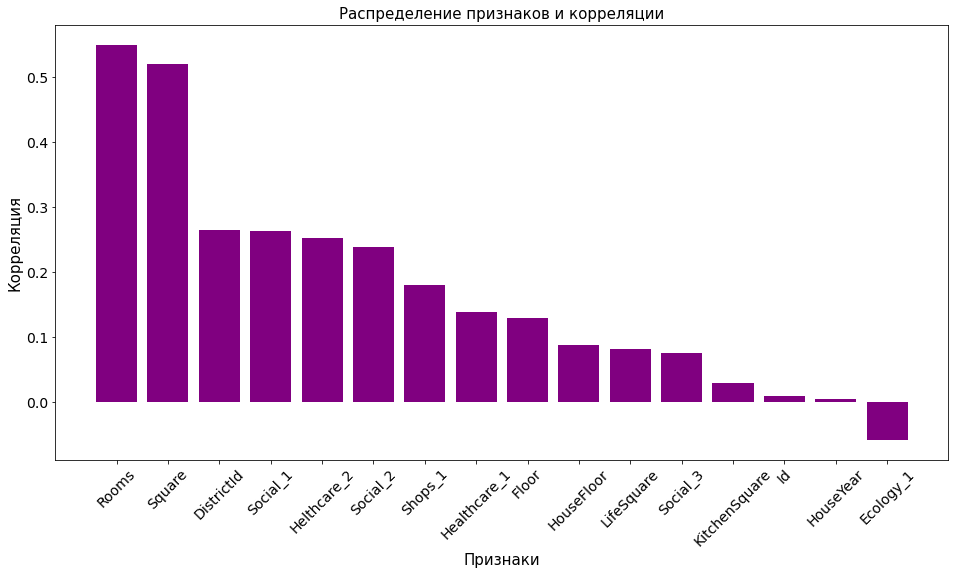

In [10]:
correlation = train_df.corrwith(train_df['Price']).sort_values(ascending=False)
correlation.drop('Price', inplace=True)

plt.figure(figsize = (16, 8))
plt.bar(correlation.index, correlation, color = 'purple')
plt.xticks(rotation='45')
plt.xlabel('Признаки', fontsize=15)
plt.ylabel('Корреляция', fontsize=15)
plt.title('Распределение признаков и корреляции', fontsize=15)
plt.show()

# Обработка данных и генерация признаков

In [11]:
class DataPreprocessor:
    def __init__(self):
        self.medians = None
        self.kitchen_square_max_value = None
        self.kitchen_square_min_value = None
        self.life_square_min_value = None
        self.max_floor = None
        self.districts_healthcare = None


        
    def fit(self, df):
        # Медианы и квантили
        self.medians = df.median() # медианы
        self.kitchen_square_max_value = np.quantile(df['KitchenSquare'], q=0.999) 
        self.kitchen_square_min_value = np.quantile(df['KitchenSquare'], q=0.001) 
        self.life_square_min_value = np.quantile(df['LifeSquare'], q=0.03) 
        self.max_floor = df['Floor'].max()
        
        
        # Вычисляем среднее значение Helthcare_1 в каждом районе
        self.districts_healthcare = df.groupby(['DistrictId'])['Healthcare_1'].agg('mean').to_dict()


    def transform(self, df):
        # заменяем на полную жилую площадь
        df['LifeSquare'].fillna(((df['Square'] - df['KitchenSquare']) - df['Square']*0.2), inplace=True)


        # Rooms
        # Добавляем медианы         
        df['Rooms'].fillna(self.medians.Rooms, inplace=True) 
        
        # Вычисляем медианную площадь комнаты и заполняем выбросы с помощью LifeSquare/Room_square 
        condition_rooms = (df['Rooms'] > 6) | (df['Rooms'] == 0)   
        room_sq = np.round((self.medians.LifeSquare / self.medians.Rooms, 1))[0]
        df.loc[condition_rooms , 'Rooms'] = df.loc[condition_rooms, 'LifeSquare'] / room_sq

        # Square
        # Если LifeSquare > Square: изменяем значения
        df['Square'], df['LifeSquare'] = np.where(df['Square'] < df['LifeSquare'],(df['LifeSquare'],df['Square']), (df['Square'],df['LifeSquare']))


        # LifeSquare
        # Заполяняем выбросы с помощью (Square - KithcenSquare)
        ls_condition = (df['LifeSquare'] < self.life_square_min_value)
        df.loc[ls_condition, 'LifeSquare'] = df.loc[ls_condition, ['Square']] - df.loc[ls_condition, ['KitchenSquare']]
  
        
        # KitchenSquare
        # Заполняем выбросы с помощью (Square - LifeSquare - 10% of Square)
        condition_kitchen_square = (df['KitchenSquare'] > self.kitchen_square_max_value) | (df['KitchenSquare'] < self.kitchen_square_min_value)
        df.loc[condition_kitchen_square, 'KitchenSquare'] = df.loc[condition_kitchen_square, 'Square'] - df.loc[condition_kitchen_square, 'LifeSquare'] \
        - (df.loc[condition_kitchen_square, 'Square'] * 0.1)


        # Ecology and Shops
        # Заменяем буквы на цифры
        df.replace({'Ecology_2': {'A': 0, 'B': 1}}, inplace=True)
        df.replace({'Ecology_3': {'A': 0, 'B': 1}}, inplace=True)
        df.replace({'Shops_2': {'A': 0, 'B': 1}}, inplace=True)
        
        
        # HouseFloor
        # Если HouseFloor < Floor: изменяем значения
        house_floor_condition = df['HouseFloor'] < df['Floor']
        df.loc[house_floor_condition, 'HouseFloor'] = df.loc[house_floor_condition, 'Floor']

        
        # HouseYear
        # Если HouseYear > current year устанавливаем медианное значение
        current_year = datetime.now().year
        condition_year = (df['HouseYear'] > current_year)
        df.loc[condition_year, 'HouseYear'] = self.medians.HouseYear
        
        
        # Healthcare
        # Добавляем районные значения для здравоохранения. (Если район не имеет значения для здравоохранения, добавляем медианы)      
        df.loc[df['Healthcare_1'].isna(), 'Healthcare_1'] = df['DistrictId'].map(self.districts_healthcare)
        df['Healthcare_1'].fillna(self.medians.Healthcare_1, inplace=True)       
        # Clip on upper quantille
        q_max = np.quantile(df['Healthcare_1'], q=0.9)
        df['Healthcare_1'].clip(upper=q_max, axis=0, inplace=True)
        
        
        # Удаляем Id
        df.drop(['Id'], axis=1, inplace=True)

        
        # Добавляем на всякий случай
        df.fillna(self.medians, inplace=True)
        return df




In [12]:
class FeatureGenerator:
    def __init__(self):
        self.districts_median_year = None
        self.districts_density = None
        self.district_price_per_square = None
        self.min_sq = None
        self.max_sq = None

        
    def fit(self, df):   
        self.min_sq = np.quantile(df['Square'], q=0.005)
        self.max_sq = np.quantile(df['Square'], q=0.995)
        
        self.districts_median_year = df.groupby(['DistrictId'])['HouseYear'].agg('median').to_dict()  # median house year in each district
        self.districts_density = df.groupby(['DistrictId'])['Square'].agg('median').to_dict()  # median square in each district
        self.district_price_per_square = df.groupby(['DistrictId'])['Price'].agg('median') \
        / df.groupby(['DistrictId'])['Square'].agg('median')  # median price for square meter in each district
        
    
    def new_features(self, df):
        # How old is the district      
        df['DistrictYear'] = df['DistrictId'].map(self.districts_median_year)
        
        self.median_district_year = df['DistrictYear'].median()
        df['DistrictYear'].fillna(self.median_district_year, inplace=True)


        # Median square of flat in each district
        df['DistrictDensity'] = df['DistrictId'].map(self.districts_density)
        
        self.median_district_density = df['DistrictDensity'].median()
        df['DistrictDensity'].fillna(self.median_district_density, inplace=True)


        # Median price for square meter in each district
        self.district_price_per_square.to_dict()
        df['DistrictPrice'] = df['DistrictId'].map(self.district_price_per_square)
        
        self.median_district_price_per_square = df['DistrictPrice'].median()
        df['DistrictPrice'].fillna(self.median_district_price_per_square, inplace=True)


        # Floor category
        floor_bins = [0, 4, 7, 12, df['Floor'].max()]
        df['Floor_cat'] = pd.cut(df['Floor'], bins=floor_bins, labels=False)
        df['Floor_cat'].fillna(-1, inplace=True) 

        
        # Scale and merge Social
        scaler = RobustScaler()
        pca = PCA(n_components=1, random_state=42)
        social_scaled = pd.DataFrame(scaler.fit_transform(df[['Social_1', 'Social_2', 'Social_3']]))
        df['Social'] = pca.fit_transform(social_scaled)
        
        
        df.drop(['Ecology_2', 'Ecology_3', 'Shops_2', 'Helthcare_2', 'Floor',], axis=1, inplace=True)
        
        return df
    
    
    def drop_outliers(self, df):
        df = df.loc[(df['Square'] > self.min_sq) & (df['Square'] < self.max_sq)]
        
        
        
        return df


__Обработка данных__

In [13]:
preprocessor = DataPreprocessor()
preprocessor.fit(train_df)
train_df = preprocessor.transform(train_df)
test_df = preprocessor.transform(test_df)

__Генерация признаков__

In [14]:
features_gen = FeatureGenerator()
features_gen.fit(train_df)
train_df = features_gen.new_features(train_df)
train_df = features_gen.drop_outliers(train_df)
test_df = features_gen.new_features(test_df)

__Разбиение на train, valid__

In [15]:
y = pd.DataFrame(data=train_df['Price'])
train_df.drop('Price', axis=1, inplace=True)
X_train, X_test, y_train, y_test = train_test_split(train_df, y, test_size=0.15, random_state=100)

__Построение наилучшей модели на Gradient Boosting Regressor__

In [17]:
gb_model = GradientBoostingRegressor(criterion='mse',
                                     max_depth=7,
                                     min_samples_leaf=7,
                                     random_state=42,  
                                     n_estimators=2500, 
                                     max_features='sqrt', 
                                     loss='huber', 
                                     learning_rate=0.01)

gb_model.fit(X_train, y_train)

y_train_preds = gb_model.predict(X_train)
y_test_preds = gb_model.predict(X_test)
print(r2(y_train, y_train_preds))
print(r2(y_test, y_test_preds))

0.9043064875217608
0.7963523000386501


__Важность признаков__

In [18]:
feature_importances = pd.DataFrame(zip(X_train.columns, 
                                       gb_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False, inplace=True)
feature_importances

,feature_name,importance
2,Square,0.257739
15,DistrictPrice,0.159836
1,Rooms,0.122329
3,LifeSquare,0.078782
9,Social_2,0.066343
8,Social_1,0.058106
4,KitchenSquare,0.039445
17,Social,0.034416
6,HouseYear,0.028269
10,Social_3,0.024931


__Предсказание тестового набора данных и отправка в kaggle__

In [19]:
test_df.head(2)

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Shops_1,DistrictYear,DistrictDensity,DistrictPrice,Floor_cat,Social
0,44,1.0,36.847630,19.094182,5.0,9.0,1970,0.036122,24,4378,0,1036.0,1,1977.0,46.971646,4431.704675,1,-1.654285
1,62,1.0,42.568133,42.493907,10.0,17.0,2017,0.072158,2,629,1,2300.0,0,1977.0,56.667328,2859.977368,1,-1.462656


In [20]:
X_train.head(2)

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Shops_1,DistrictYear,DistrictDensity,DistrictPrice,Floor_cat,Social
8785,134,2.0,39.697957,25.214448,7.0,9.0,1969,0.015017,17,3079,59,2300.0,8,1977.0,42.382091,6161.829301,1,10.186171
9074,8,1.0,39.195153,22.158768,9.0,12.0,1968,0.437885,23,5735,3,1084.0,5,1983.0,47.651571,3975.516530,2,-1.007192


In [21]:
submit = pd.read_csv('sample_submission.csv')
submit.head()

,Id,Price
0,4567,200000.0
1,5925,200000.0
2,960,200000.0
3,3848,200000.0
4,746,200000.0


In [22]:
predictions = gb_model.predict(test_df)
predictions

array([157616.35649686, 122930.01879599, 136015.0128913 , ...,
       149902.23115219, 185593.45046475, 292952.38334725])

In [23]:
submit['Price'] = predictions
submit.head()

,Id,Price
0,4567,157616.356497
1,5925,122930.018796
2,960,136015.012891
3,3848,96605.905520
4,746,182360.444868


In [24]:
submit.shape

(5000, 2)

In [25]:
submit.to_csv('gb_submit.csv', index=False)